In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
card_df.shape

(284807, 31)

In [3]:
# Class 피처 안에 1과 0의 비율
card_df.Class.value_counts()[1]/card_df.Class.value_counts()[0]*100

0.17304750013189596

In [4]:
card_df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [5]:
# 데이터 일차 가공 및 모델 학습/예측/평가
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [6]:
# 사전 데이터 가공 후, 학습과 테스트 세트를 반환하는 함수
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    x_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    return x_train,x_test,y_train,y_test

x_train,x_test,y_train,y_test = get_train_test_dataset(card_df)

In [7]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [8]:
# 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [9]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(x_train,y_train)
lr_pred = lr_clf.predict(x_test)
lr_pred_proba = lr_clf.predict_proba(x_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8679, 재현율: 0.6216,    F1: 0.7244, AUC:0.9706


In [10]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [11]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, x_train, x_test, y_train, y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


과제_0922_1. 상기 과제에 대하여 아래 다음을 수행하세요.
- 데이터 분포도 변환 후 모델 학습/예측/평가
- 이상치 데이터 제거 후 모델 학습/예측/평가
- SMOTE 오버샘플링 적용 후, 모델 학습/예측/평가

In [12]:
# !pip install scikit-learn==0.23.1 --user
# !pip install imbalanced_learn==0.7.0 --user

In [13]:
from imblearn.over_sampling import SMOTE

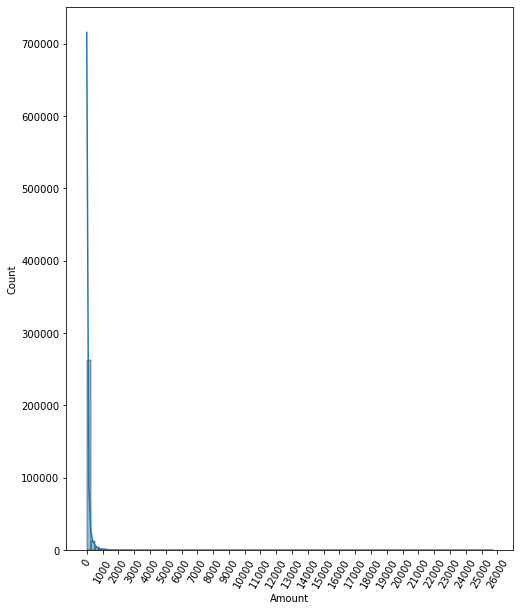

In [14]:
import seaborn as sns
# 데이터 분포도 확인
plt.figure(figsize=(8,10))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

- Amount, 즉 카드 사용금액이 1000불 이하인 데이터가 대부분이며, 26000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있다. Amount 표준 정규화가 시도 

In [15]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [16]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, x_train, x_test, y_train, y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, x_train, x_test, y_train, y_test)

# 정규화 후, 로지스틱 회귀의 경우, 정밀도와 재현율이 오히려 조금 저하되었고 LightGBM의 경우, 약간 정밀도와 재현율이 저하되었다.

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


In [17]:
# 로그변환 수행
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [18]:
x_train,x_test,y_train,y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, x_train, x_test, y_train, y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, x_train, x_test, y_train, y_test)

# 로지스틱 회귀의 경우 원본 데이터 대비 정밀도는 향상되었지만 재현율은 저하되었다. LightGBM의 경우, 재현율이 향상되었다.
# 레이블이 극도로 불균일한 데이터 세트에서 로지스틱 회귀는 데이터 변환 시 약간은 불안정한 성능 결과를 보여주고 있다.

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


<AxesSubplot:>

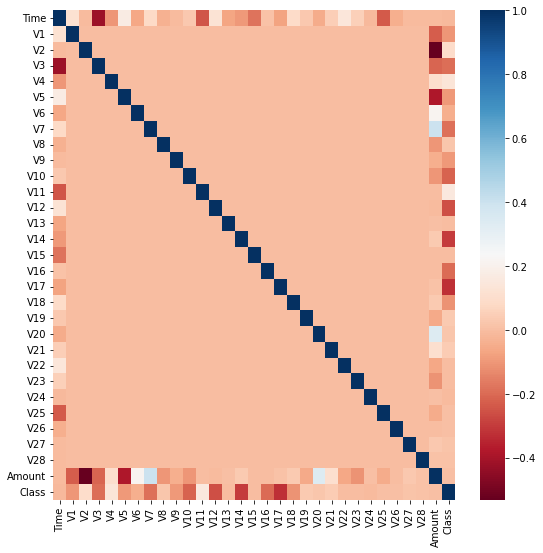

In [19]:
# 히트맵을 통한 피처별 상관도 시각화
# 이상치 검출 시, 레이블값과 상관성이 높은 피처들을 위주로 이상치를 검출한다.
# 모든 피처들의 이상치를 검출하는 것은 시간이 많이 소모되며, 
# 결정값과 상관성이 높지 않은 피처들의 경우, 이상치를 제거하더라도 성능 향상에 기여하지 않는다.
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

# 상관관계 히트맵에서 결정 레이블인 'Class'피처와 음의 상관관계가 가장 높은 피처는 v14, v17로 나온다.

In [20]:
card_df[card_df['Class']==1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [21]:
# 이상치 검출 함수, IQR 계산 인자 weight
import numpy as np
def get_outlier(df=None, column = None,weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함.
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
    outlier_index = fraud[(fraud < lowest_val)|(fraud > highest_val)].index
    return outlier_index


In [22]:
outlier_index = get_outlier(card_df, 'V14', 1.5)
print('이상치 데이터 인덱스 : ', outlier_index)
# 4개의 이상치 검출
outlier_index2 = get_outlier(card_df, 'V17', 1.5)
print(outlier_index2)
# 레이블과 상관관계가 높았던 V17의 경우, 이상치가 존재하지 않는다. 

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')
Int64Index([], dtype='int64')


In [23]:
# get_preprocessed_df()를 로그 변환 후, V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df_copy, column='V14', weight = 1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

x_train, x_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, x_train, x_test, y_train, y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, x_train, x_test, y_train, y_test)
# 이상치를 제거한 후, 로지스틱 회귀와 lightgbm 모두 예측 성능이 크게 향상되었다. 로지스틱 회귀의 경우, 재현율이 60.14%에서 67.12%로 크게 증가
# LightGBM의 경우도 76.35%에서 82.88%로 크게 증가했다.

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


#### SMOTE 오버샘플링
- SMOTE를 적용할 때는 반드시 학습 데이터만 오버샘플링을 해야 한다.
- 검증데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우 
- 결국은 원본 데이터가 아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없다.

In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
x_train_over, y_train_over = smote.fit_resample(x_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', x_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', x_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n', pd.Series(y_train_over).value_counts())

# SMOTE 적용 전 학습데이터는 199362건이었지만 적용 후, 2배 가까운 398040 건으로 증식되었다. 
# 적용 후 레이블 값이 0과 1의 분포가 동일하게 생성된 것을 확인

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 0    199020
1    199020
Name: Class, dtype: int64


In [25]:
lr_clf = LogisticRegression(max_iter = 1000)
# ftr_train과 tgt_train 인자 값이 SMOTE 증식된 x_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, x_train_over, x_test, y_train_over, y_test)
# 로지스틱 회귀모델의 경우 SMOTE로 오버샘플링된 데이터로 학습할 경우, 재현율이 92.47%로 크게 증가하지만 
# 반대로 정밀도가 5.4%로 급격하게 저하된다. 재현율이 높더라도 이 정도의 정밀도로는 현실 업무에 적용 불가
# 이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서
# 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 저밀도가 급격히 떨어지게 된 것입니다. 
# 분류 결정 임곗값에서 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


In [26]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1단위로 변경
    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

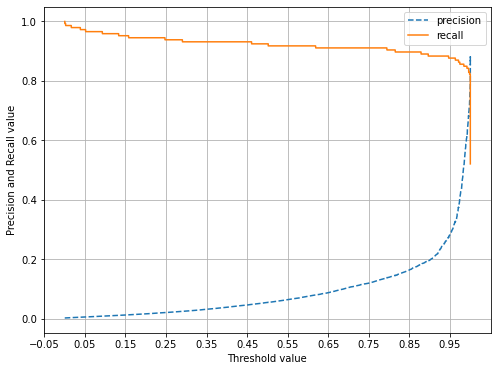

In [27]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(x_test)[:,1])

In [28]:
# 임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아집니다. 
# 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀모델의 경우 SMOTE 적용 후 올바른 예측모델이 생성되지 못했다.

In [29]:
# LightGBM으로 SMOTE 오버샘플링된 데이터 세트로 학습/예측/평가 진행

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, x_train_over, x_test, y_train_over, y_test)

# 재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.88%가 되었다. 그러나 정밀도는 이전의 96.03%보다 낮은 91.18%이다. 
# SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적이다. 
# 정밀도 지표보다는 재현율 지표를 높이는 것이 머신러닝 모델의 주요한 목표인 경우 SMOTE를 적용하면 좋다.
# 좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식한다.

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


#### 전체 예측도 평가 비교


1. 데이터 전처리 후, 로지스틱 회귀 예측모델 평가
````
오차 행렬
[[85281    14]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8679, 재현율: 0.6216,    F1: 0.7244, AUC:0.9706
````
2. 데이터 전처리 후, LightGBM모델 예측모델 평가
````
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790
````
3. 정규화 후 평가

로지스틱 회귀 예측 성능
````
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
`````
LightGBM 예측 성능
````
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779
````

4. 로그변환 후 평가

로지스틱 회귀 예측 성능
````
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
````
LightGBM 예측 성능
````
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796
````

5. SMOTE 오버샘플링 학습데이터에 적용 후 평가

로지스틱 회귀 예측 성능
`````
오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737
`````
LightGBM 예측 성능
````
오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814
````